In [1]:
import datetime
import json
import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import redis

# Generate Traces

Generate 100 traces for the openstack command image list:
+ $ for i in {1..100}; do openstack image list --os-profile SECRET_KEY; done 

List/show the traces generated:
+ osprofiler trace list --connection-string redis://localhost:6379 

# Inspect Redis
Inspect the traces ids stored in Redis using Python redis library

In [2]:
r = redis.Redis()
base_trace_ids = r.keys("osprofiler_opt:*")
print('# base traces:', len(base_trace_ids))
base_trace_ids

# base traces: 100


[b'osprofiler_opt:8936de06-bbf3-47a5-b86c-a3b960667538',
 b'osprofiler_opt:8d53535a-ddb4-4c8f-bbcb-1cde0a8a5b42',
 b'osprofiler_opt:97a91378-08e5-4a24-adeb-6e007d9494b8',
 b'osprofiler_opt:587aeb38-bb14-4dcd-b700-9167cec66ab8',
 b'osprofiler_opt:8b50d7aa-5597-4478-9331-b5df1ae3e65f',
 b'osprofiler_opt:4ed27c73-ecec-411d-b931-e00f8c2a2af3',
 b'osprofiler_opt:9478baae-2a54-4a54-b037-f6c5af499f91',
 b'osprofiler_opt:05084b40-2560-4108-aa89-6bc6514709f3',
 b'osprofiler_opt:9ea489f4-b591-4b44-a60d-c653e523527a',
 b'osprofiler_opt:6a67db1d-d997-423e-816e-ad148f6552bc',
 b'osprofiler_opt:898f3f7d-7470-417a-a481-6749c9c8b5f3',
 b'osprofiler_opt:4d7e2dda-266c-419d-90b1-8e413e9b88a4',
 b'osprofiler_opt:fd963416-46f4-4564-966b-09e02d741531',
 b'osprofiler_opt:68a86079-7add-49d1-9bf4-892d5c3bb883',
 b'osprofiler_opt:71aa5063-10db-4836-9c93-ed24f04ef705',
 b'osprofiler_opt:bebfab87-7a3a-4ea8-a5b7-2761993266fb',
 b'osprofiler_opt:df4a4e20-123c-4a22-ac92-0cf98a092de0',
 b'osprofiler_opt:dd4048ce-374b

# Single Trace Analysis
+ Retrieve the first trace
+ Remove the spans which describe a database access
+ Identify the span that had the longest duration

In [5]:
print('Retrieving base trace id', base_trace_ids[0])
span_lst = r.lrange(base_trace_ids[0], 0, -1)
span_lst_short = []
for span in span_lst:
    span = json.loads(span)
    if 'db-' in span['name']:
        continue
    span_lst_short.append(span)
print('Base trace len:', len(span_lst_short))

Retrieving trace id b'osprofiler_opt:8936de06-bbf3-47a5-b86c-a3b960667538'
Base trace len: 12


In [6]:
# Show the span content
for span in span_lst_short:
    pprint.pprint(span)

{'base_id': '8936de06-bbf3-47a5-b86c-a3b960667538',
 'info': {'host': 'osboxes'},
 'name': 'wsgi-stop',
 'parent_id': '8936de06-bbf3-47a5-b86c-a3b960667538',
 'project': 'glance',
 'service': 'api',
 'timestamp': '2019-12-04T08:18:45.478038',
 'trace_id': '1cef1dbe-5b10-453c-b9a8-786e53ad141f'}
{'base_id': '8936de06-bbf3-47a5-b86c-a3b960667538',
 'info': {'host': 'osboxes',
          'request': {'method': 'GET',
                      'path': '/v2/images',
                      'query': 'marker=49e6b32c-6da0-49c8-9501-f7cb5d24fc03',
                      'scheme': 'http'}},
 'name': 'wsgi-start',
 'parent_id': '8936de06-bbf3-47a5-b86c-a3b960667538',
 'project': 'glance',
 'service': 'api',
 'timestamp': '2019-12-04T08:18:45.460197',
 'trace_id': '1cef1dbe-5b10-453c-b9a8-786e53ad141f'}
{'base_id': '8936de06-bbf3-47a5-b86c-a3b960667538',
 'info': {'host': 'osboxes'},
 'name': 'wsgi-stop',
 'parent_id': '8936de06-bbf3-47a5-b86c-a3b960667538',
 'project': 'glance',
 'service': 'api',
 'time

In [7]:
# Stats about base traces
for os_obj in ['project', 'name', 'service']:
    print(os_obj+'s:', set([span[os_obj] for span in span_lst_short]))

projects: {'keystone', 'glance'}
names: {'wsgi-start', 'wsgi-stop'}
services: {'public', 'api'}


In [9]:
import dateutil.parser

# Create a dictionary to group spans with the same trace id
span_dct = {}
for span in span_lst_short:
    datetime_object = dateutil.parser.parse(span['timestamp']) 
    span_dct.setdefault(span['trace_id'], []).append(datetime_object)
print('Number of traces', len(span_dct))

Number of traces 6


In [12]:
# calculate the duration of traces
span_duration = {}
for key in span_dct:
    span_dct[key] = sorted(span_dct[key], key=lambda x: x.now().timestamp(), reverse=True)
    duration = span_dct[key][-1] - span_dct[key][0]
    print('Duration:', duration, ',', 'trace id:', key)
    span_duration[key] = duration

Duration: 0:00:00.017841 , trace id: 1cef1dbe-5b10-453c-b9a8-786e53ad141f
Duration: 0:00:00.045977 , trace id: 82fe4df5-6738-4f0b-9dfb-d145c61348da
Duration: 0:00:00.028781 , trace id: 32305f75-649f-4d6d-b339-9266c4cfc3ea
Duration: 0:00:00.018548 , trace id: bdf7ec45-ef86-402e-87db-6787b827eb75
Duration: 0:00:00.019295 , trace id: 2f7b11bb-135b-45cc-a653-4c707a538c95
Duration: 0:00:00.002342 , trace id: 912e9bca-e94d-4492-8ba9-1f7fb825cd51


In [8]:
# The trace with the longest duration
max_span = max(span_duration, key=span_duration.get)
print('trace:', max_span)

trace: b3ade71c-c13d-4c75-884c-46cf58799b9f


In [9]:
for span in span_lst_short:
    if span['trace_id'] == max_span:
        pprint.pprint(span)

{'base_id': '21f5d06c-0d01-48f8-a1ae-1d4a0fba1190',
 'info': {'host': 'osboxes'},
 'name': 'wsgi-stop',
 'parent_id': '21f5d06c-0d01-48f8-a1ae-1d4a0fba1190',
 'project': 'keystone',
 'service': 'public',
 'timestamp': '2019-12-04T08:16:40.860976',
 'trace_id': 'b3ade71c-c13d-4c75-884c-46cf58799b9f'}
{'base_id': '21f5d06c-0d01-48f8-a1ae-1d4a0fba1190',
 'info': {'host': 'osboxes',
          'request': {'method': 'GET',
                      'path': '/identity/',
                      'query': '',
                      'scheme': 'http'}},
 'name': 'wsgi-start',
 'parent_id': '21f5d06c-0d01-48f8-a1ae-1d4a0fba1190',
 'project': 'keystone',
 'service': 'public',
 'timestamp': '2019-12-04T08:16:40.858534',
 'trace_id': 'b3ade71c-c13d-4c75-884c-46cf58799b9f'}


# Multi Trace Analysis
+ Remove the spans which describe a database access
+ Retrieve the first trace and identify the span that had the longest duration

In [15]:
base_id_dct = {}
for base_trace_id in base_trace_ids:
    print('Retrieving base trace id', base_trace_id)
    span_lst = r.lrange(base_trace_id, 0, -1)
    for span in span_lst:
        span = json.loads(span)
        datetime_object = dateutil.parser.parse(span['timestamp']) 
        base_id_dct.setdefault(span['base_id'], []).append(datetime_object)

Retrieving base trace id b'osprofiler_opt:8936de06-bbf3-47a5-b86c-a3b960667538'
Retrieving base trace id b'osprofiler_opt:8d53535a-ddb4-4c8f-bbcb-1cde0a8a5b42'
Retrieving base trace id b'osprofiler_opt:97a91378-08e5-4a24-adeb-6e007d9494b8'
Retrieving base trace id b'osprofiler_opt:587aeb38-bb14-4dcd-b700-9167cec66ab8'
Retrieving base trace id b'osprofiler_opt:8b50d7aa-5597-4478-9331-b5df1ae3e65f'
Retrieving base trace id b'osprofiler_opt:4ed27c73-ecec-411d-b931-e00f8c2a2af3'
Retrieving base trace id b'osprofiler_opt:9478baae-2a54-4a54-b037-f6c5af499f91'
Retrieving base trace id b'osprofiler_opt:05084b40-2560-4108-aa89-6bc6514709f3'
Retrieving base trace id b'osprofiler_opt:9ea489f4-b591-4b44-a60d-c653e523527a'
Retrieving base trace id b'osprofiler_opt:6a67db1d-d997-423e-816e-ad148f6552bc'
Retrieving base trace id b'osprofiler_opt:898f3f7d-7470-417a-a481-6749c9c8b5f3'
Retrieving base trace id b'osprofiler_opt:4d7e2dda-266c-419d-90b1-8e413e9b88a4'
Retrieving base trace id b'osprofiler_op

In [16]:
# calculate the duration of spans / traces
duration_dct = {}
for base_id in base_id_dct:
    base_id_dct[base_id] = sorted(base_id_dct[base_id], key=lambda x: x.now().timestamp(), reverse=True)
    duration = base_id_dct[base_id][-1] - base_id_dct[base_id][0]
    print('Duration:', duration, ',', 'base trace id:', base_id)
    duration_dct[base_id] = duration

Duration: 0:00:00.185118 , base trace id: 8936de06-bbf3-47a5-b86c-a3b960667538
Duration: 0:00:00.207269 , base trace id: 8d53535a-ddb4-4c8f-bbcb-1cde0a8a5b42
Duration: 0:00:00.184706 , base trace id: 97a91378-08e5-4a24-adeb-6e007d9494b8
Duration: 0:00:00.244420 , base trace id: 587aeb38-bb14-4dcd-b700-9167cec66ab8
Duration: 0:00:00.226668 , base trace id: 8b50d7aa-5597-4478-9331-b5df1ae3e65f
Duration: 0:00:00.192099 , base trace id: 4ed27c73-ecec-411d-b931-e00f8c2a2af3
Duration: 0:00:00.256199 , base trace id: 9478baae-2a54-4a54-b037-f6c5af499f91
Duration: 0:00:00.233075 , base trace id: 05084b40-2560-4108-aa89-6bc6514709f3
Duration: 0:00:00.186619 , base trace id: 9ea489f4-b591-4b44-a60d-c653e523527a
Duration: 0:00:00.195919 , base trace id: 6a67db1d-d997-423e-816e-ad148f6552bc
Duration: 0:00:00.187590 , base trace id: 898f3f7d-7470-417a-a481-6749c9c8b5f3
Duration: 0:00:00.285886 , base trace id: 4d7e2dda-266c-419d-90b1-8e413e9b88a4
Duration: 0:00:00.179857 , base trace id: fd963416-4

In [65]:
# Display the duration of the traces
df = pd.DataFrame.from_dict(duration_dct, orient='index', columns=['duration'])
df['duration'] = df['duration'] / datetime.timedelta(milliseconds=1)
df = df.reset_index()

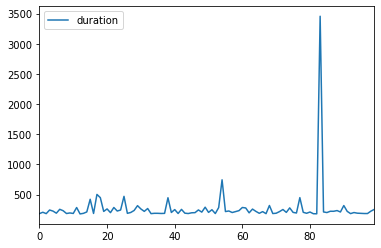

In [68]:
# Plot durations
df.plot()

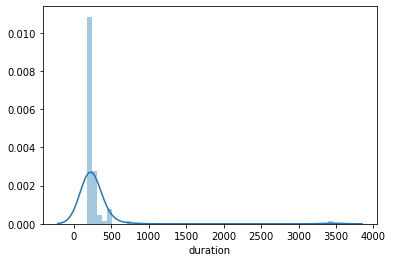

In [69]:
# Plot PDF od durations
sns.distplot(df['duration'])

# Anomaly Detection

# Z-score
The Z-score is the signed number of standard deviations by which the value of an observation or data point is above the mean value of what is being observed or measured [Wikipedia].

In [ ]:
import numpy as np

def outliers_z_score(ys):
    threshold = 3

    mean_y = np.mean(ys)
    stdev_y = np.std(ys)
    z_scores = [(y - mean_y) / stdev_y for y in ys]
    return np.where(np.abs(z_scores) > threshold)

In [73]:
from scipy import stats
import numpy as np
z = np.abs(stats.zscore(df['duration']))
print(z)
threshold = 3
print(np.where(z > 3))

[2.61864064e-01 1.94863618e-01 2.63110247e-01 8.24924579e-02
 1.36187186e-01 2.40748534e-01 4.68643484e-02 1.16807841e-01
 2.57323968e-01 2.29194125e-01 2.54386971e-01 4.29303445e-02
 2.77777086e-01 2.49423414e-01 1.78723743e-01 4.56175884e-01
 2.54326476e-01 6.99946682e-01 5.37404586e-01 1.52859411e-01
 2.78540191e-02 2.13695489e-01 4.43005401e-02 1.32061476e-01
 8.24712849e-02 6.02559956e-01 2.48346616e-01 2.05238388e-01
 1.04167560e-01 1.35952408e-01 3.00560111e-02 1.50854025e-01
 7.30411030e-03 2.63415743e-01 2.46976421e-01 2.47656981e-01
 2.55699697e-01 2.50197741e-01 5.32301893e-01 2.06315186e-01
 6.09353192e-02 2.55947723e-01 5.06270930e-02 2.40588224e-01
 2.58307000e-01 2.21456906e-01 2.14016109e-01 7.80400785e-02
 1.87828133e-01 5.94694822e-02 2.01043109e-01 6.78921621e-02
 2.58778856e-01 4.06587841e-02 1.43191846e+00 1.59280879e-01
 1.31014924e-01 2.07600690e-01 1.61259043e-01 1.14058376e-01
 4.44215286e-02 2.02994322e-02 2.23017659e-01 3.56093865e-02
 1.50379145e-01 2.465922

# Boxplot
In descriptive statistics, a box plot is a method for graphically depicting groups of numerical data through their quartiles. Box plots may also have lines extending vertically from the boxes (whiskers) indicating variability outside the upper and lower quartiles, hence the terms box-and-whisker plot and box-and-whisker diagram. Outliers may be plotted as individual points. [Wikipedia]

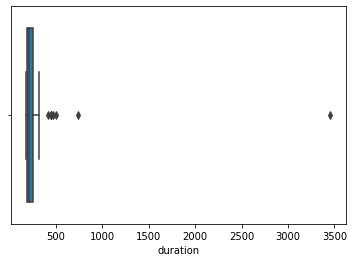

In [71]:
import seaborn as sns
sns.boxplot(x=df['duration'])

In [ ]:
import numpy as np

def outliers_iqr(ys):
    quartile_1, quartile_3 = np.percentile(ys, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    return np.where((ys > upper_bound) | (ys < lower_bound))

In [74]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

duration    63.02125
dtype: float64


In [76]:
print(df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))

    duration  index
0      False  False
1      False  False
2      False  False
3      False  False
4      False  False
..       ...    ...
95     False  False
96     False  False
97     False  False
98     False  False
99     False  False

[100 rows x 2 columns]


TypeError: cannot compare a dtyped [bool] array with a scalar of type [NoneType]

# Isolation Forests
The z-score works by ...